In [105]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Install necessary packages

In [106]:
!pip install -q numpy
!pip install -q matplotlib
!pip install -q pandas
!pip install -q tensorflow
!pip install -q scikit-learn
!pip install -q pandas-datareader
!pip install -q yfinance
!pip install -q mplfinance
!pip install -q statsmodels

## Import libraries

In [107]:
import numpy as np
import pandas as pd
import yfinance as yf
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import mplfinance as mpf
import warnings
warnings.filterwarnings("ignore")

## Load and Inspect Data

In [108]:
ticker = "CBA.AX"
df = yf.download(ticker, start="2010-01-01", end="2025-01-01")[['Open','High','Low','Close','Volume']]
df.dropna(inplace=True)
print(df.head())

train_size = int(len(df) * 0.8)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]
print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

[*********************100%***********************]  1 of 1 completed

Price            Open       High        Low      Close   Volume
Ticker         CBA.AX     CBA.AX     CBA.AX     CBA.AX   CBA.AX
Date                                                           
2010-01-04  24.820239  25.002173  24.765658  24.956688   992762
2010-01-05  25.038550  25.379675  25.038550  25.334190  3163161
2010-01-06  25.475185  25.561604  25.375122  25.461540  3210425
2010-01-07  25.470640  25.684412  25.106774  25.215933  3089618
2010-01-08  25.343284  25.607087  25.320544  25.543411  3159303
Train samples: 3033, Test samples: 759


## Candlestick Chart Visual

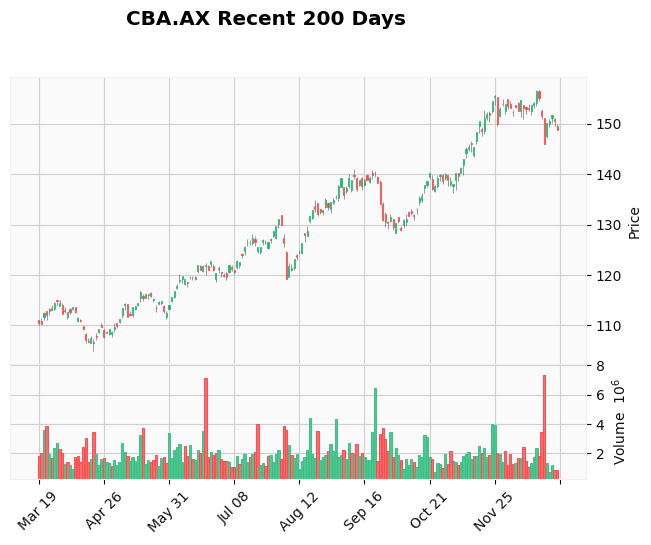

In [109]:
df_plot = df.copy()
df_plot.columns = df_plot.columns.droplevel('Ticker')
mpf.plot(df_plot.tail(200), type='candle', style='yahoo', volume=True, title=f"{ticker} Recent 200 Days")

## Data Preprocessing for LSTM and GRU

In [110]:
# --- Data Preprocessing for LSTM & GRU ---
seq_len = 60

# --- Univariate scaling (Close only) ---
scaler_uni = MinMaxScaler()
train_close_scaled = scaler_uni.fit_transform(train_df[['Close']])
test_close_scaled  = scaler_uni.transform(test_df[['Close']])

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

X_train_uni, y_train_uni = create_sequences(train_close_scaled, seq_len)
X_test_uni,  y_test_uni  = create_sequences(test_close_scaled,  seq_len)
X_train_uni = X_train_uni.reshape((-1, seq_len, 1))
X_test_uni  = X_test_uni.reshape((-1, seq_len, 1))

# --- Multivariate (OHLCV) ---
scaler_multi = MinMaxScaler()
train_feats = scaler_multi.fit_transform(train_df)
test_feats  = scaler_multi.transform(test_df)

# Separate scaler only for Close to fix 0.0 issue
scaler_close = MinMaxScaler()
train_close_scaled = scaler_close.fit_transform(train_df[['Close']])
test_close_scaled  = scaler_close.transform(test_df[['Close']])

def create_multi(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 3])   # 'Close' column
    return np.array(X), np.array(y)

X_train_multi, y_train_multi = create_multi(train_feats, seq_len)
X_test_multi,  y_test_multi  = create_multi(test_feats,  seq_len)



## Build and Train LSTM & GRU Models

In [111]:
# --- Build & Train LSTM & GRU Models ---
EPOCHS = 8
BATCH_SIZE = 64

def build_lstm(n_features=1):
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(seq_len, n_features)),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(n_features=1):
    model = Sequential([
        GRU(32, return_sequences=True, input_shape=(seq_len, n_features)),
        Dropout(0.2),
        GRU(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

print("Using device:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# --- Univariate models ---
lstm_uni = build_lstm(1)
lstm_uni.fit(X_train_uni, y_train_uni, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_split=0.1)

gru_uni = build_gru(1)
gru_uni.fit(X_train_uni, y_train_uni, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_split=0.1)

# --- Multivariate models (optional, can comment out for speed) ---
lstm_multi = build_lstm(X_train_multi.shape[2])
lstm_multi.fit(X_train_multi, y_train_multi, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

gru_multi = build_gru(X_train_multi.shape[2])
gru_multi.fit(X_train_multi, y_train_multi, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)



Using device: CPU
Epoch 1/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - loss: 0.0313 - val_loss: 0.0118
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 9.6897e-04 - val_loss: 0.0047
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 5.8115e-04 - val_loss: 0.0033
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 6.5275e-04 - val_loss: 0.0030
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 5.9995e-04 - val_loss: 0.0037
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 5.8498e-04 - val_loss: 0.0037
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 5.4298e-04 - val_loss: 0.0037
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 5.2651e-04 - val_loss: 0.0023
Epoch 1/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0637 - val_loss: 0.0193
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 6.7493e-04 - val_loss: 0.0011
Epoch 4/8
42/42 ━━━━━━

## Deep Model Predictions & RMSE

In [112]:
# --- Deep Model Predictions & RMSE ---
def inverse_scale(data, scaler):
    return scaler.inverse_transform(data.reshape(-1,1)).flatten()

# Univariate predictions
pred_lstm_uni = inverse_scale(lstm_uni.predict(X_test_uni), scaler_uni)
pred_gru_uni  = inverse_scale(gru_uni.predict(X_test_uni),  scaler_uni)
true_uni      = inverse_scale(y_test_uni, scaler_uni)

# Correct inverse scaling for multivariate
def inverse_multi_fixed(pred, y_true):
    inv_pred = scaler_close.inverse_transform(pred.reshape(-1,1)).flatten()
    inv_true = scaler_close.inverse_transform(y_true.reshape(-1,1)).flatten()
    return inv_pred, inv_true

pred_lstm_multi, true_multi = inverse_multi_fixed(lstm_multi.predict(X_test_multi), y_test_multi)
pred_gru_multi, _ = inverse_multi_fixed(gru_multi.predict(X_test_multi), y_test_multi)

def rmse(a,b):
    return np.sqrt(mean_squared_error(a,b))

print("\nRMSEs:")
print("LSTM (univariate):", rmse(true_uni, pred_lstm_uni))
print("GRU (univariate):",  rmse(true_uni, pred_gru_uni))
print("LSTM (multivariate):", rmse(true_multi, pred_lstm_multi))
print("GRU (multivariate):",  rmse(true_multi, pred_gru_multi))



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

RMSEs:
LSTM (univariate): 11.213310179227541
GRU (univariate): 7.230352243392076
LSTM (multivariate): 9.622046459785452
GRU (multivariate): 6.2904114201008925


## ARIMA and SARIMAX Models

Running ARIMA/SARIMAX with multiple configurations...
Best ARIMA order: (0, 1, 0), RMSE: 23.6500


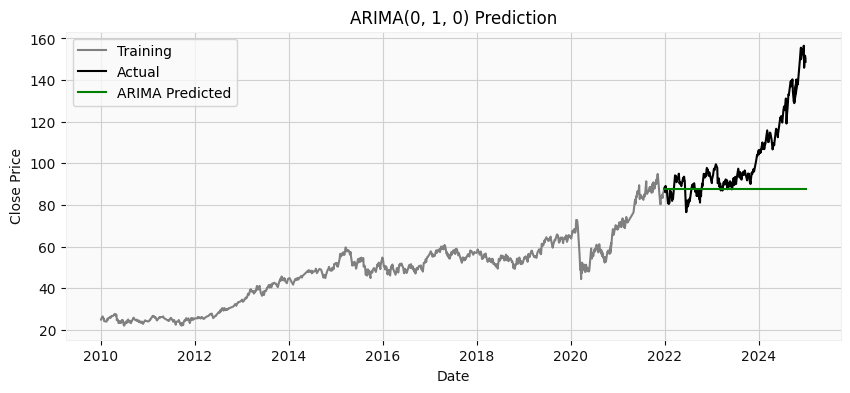

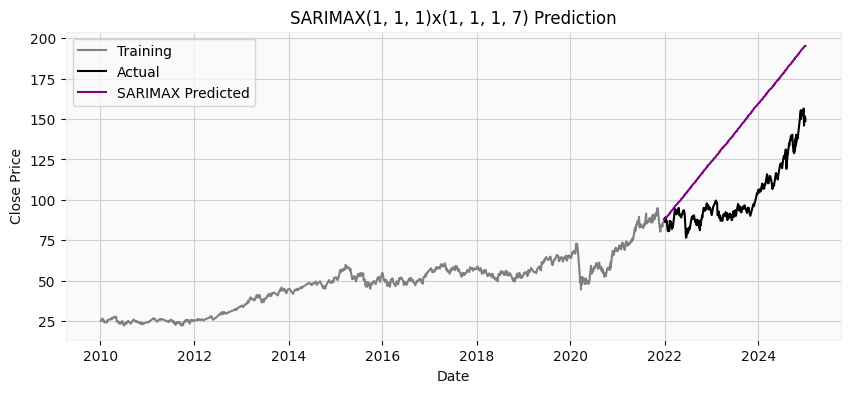


Testing Config ARIMA(0, 1, 1) / SARIMAX((0, 1, 0), (0, 1, 0, 7))
Best ARIMA order: (0, 1, 1), RMSE: 23.6920


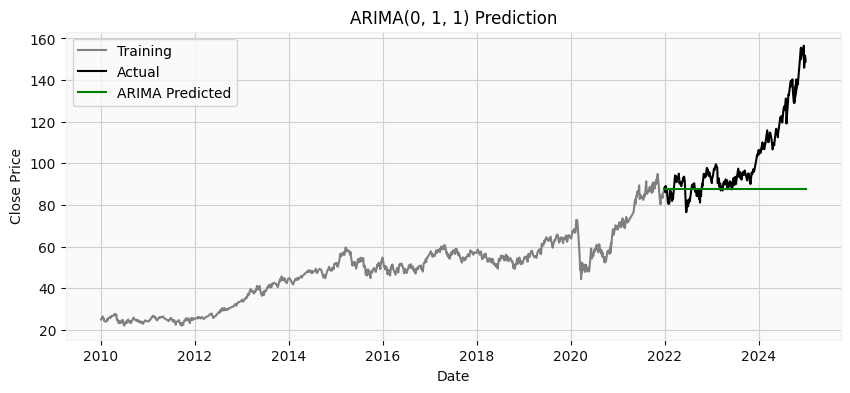

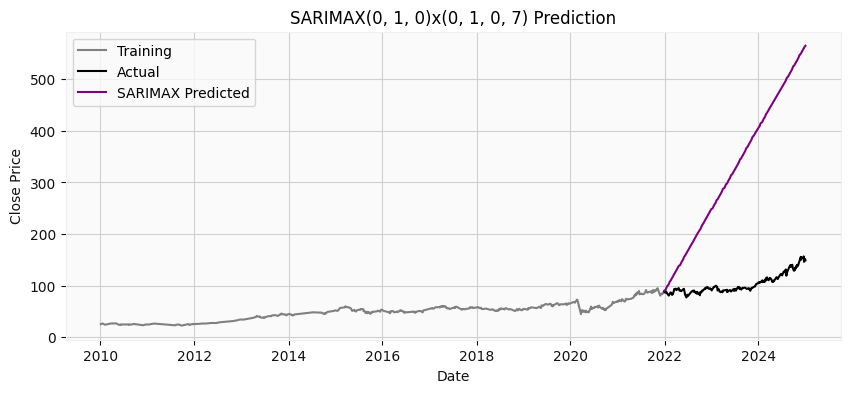


Testing Config ARIMA(1, 0, 1) / SARIMAX((1, 0, 1), (1, 0, 1, 7))
Best ARIMA order: (1, 1, 1), RMSE: 23.6876


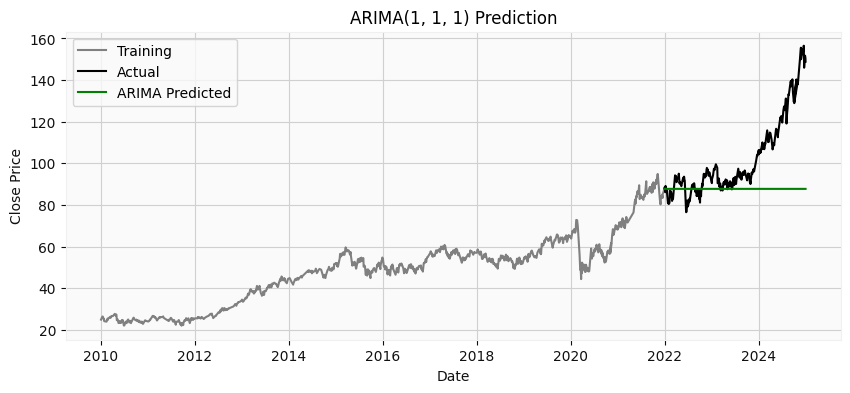

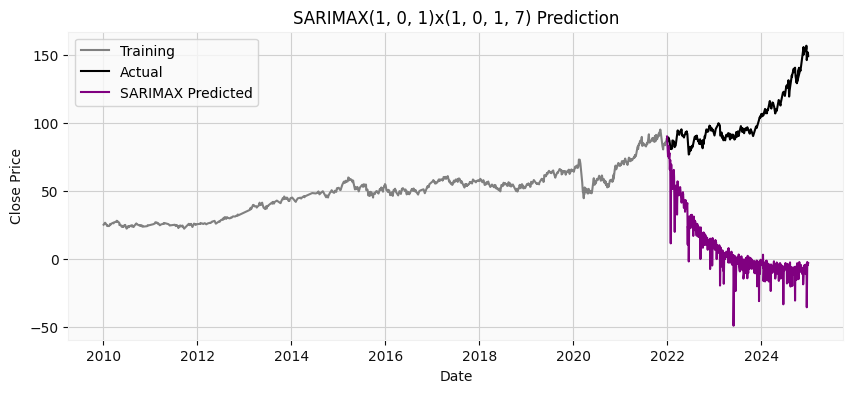


Testing Config ARIMA(0, 1, 1) / SARIMAX((0, 1, 1), (0, 1, 1, 7))
Best ARIMA order: (0, 1, 1), RMSE: 23.6920


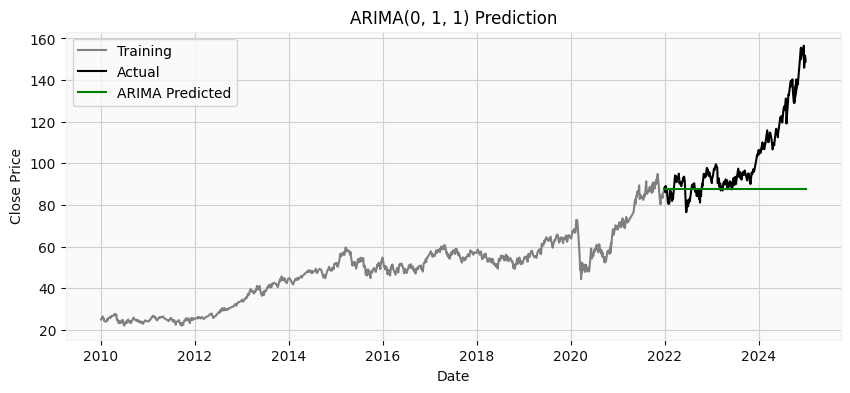

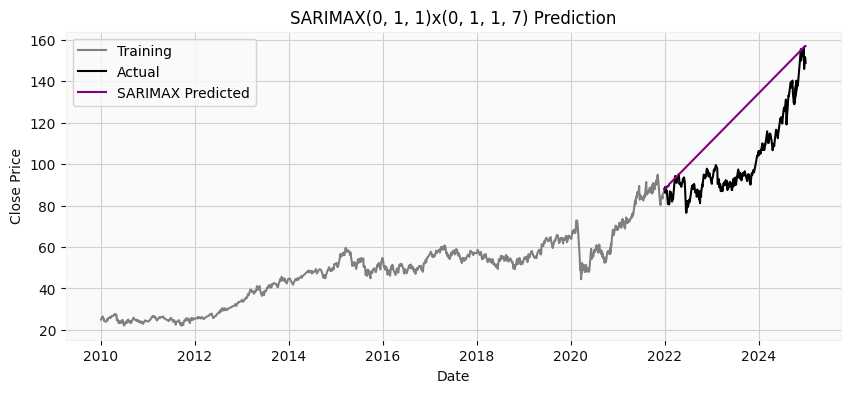


All Configurations Complete ✅


In [ ]:
# --- Helper RMSE ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --- 1. ARIMA Function ---
def arima_predict_test(train_data, test_data, start_p=0, max_p=2, start_q=0, max_q=2, d=1, seasonal=False, m=7):
    train_series = train_data['Close']
    test_series = test_data['Close']
    history = train_series.copy()

    best_cfg = None
    best_rmse = np.inf

    # --- Small grid search for best (p,d,q) ---
    for p in range(start_p, max_p + 1):
        for q in range(start_q, max_q + 1):
            try:
                model = ARIMA(history, order=(p, d, q))
                model_fit = model.fit()
                pred = model_fit.forecast(steps=len(test_series))
                score = rmse(test_series, pred)
                if score < best_rmse:
                    best_rmse = score
                    best_cfg = (p, d, q)
            except:
                continue

    # --- Final model with best order ---
    print(f"Best ARIMA order: {best_cfg}, RMSE: {best_rmse:.4f}")
    final_model = ARIMA(history, order=best_cfg)
    final_fit = final_model.fit()
    predictions = final_fit.forecast(steps=len(test_series))

    # --- Plot actual vs predicted ---
    plt.figure(figsize=(10, 4))
    plt.plot(train_series.index, train_series, label='Training', color='gray')
    plt.plot(test_series.index, test_series, label='Actual', color='black')
    plt.plot(test_series.index, predictions, label='ARIMA Predicted', color='green')
    plt.title(f"ARIMA{best_cfg} Prediction")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return predictions.values, best_rmse


# --- 2. SARIMAX Function ---
def sarimax_predict_test(train_data, test_data, order=(1,1,1), seasonal_order=(1,1,1,7)):
    train_series = train_data['Close']
    test_series = test_data['Close']
    exog_train = train_data[['Volume']]
    exog_test = test_data[['Volume']]

    # --- Fit SARIMAX model ---
    model = SARIMAX(train_series,
                    exog=exog_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(train_series),
                                    end=len(train_series)+len(test_series)-1,
                                    exog=exog_test,
                                    dynamic=False)

    # --- Calculate RMSE ---
    score = rmse(test_series, predictions)

    # --- Plot actual vs predicted ---
    plt.figure(figsize=(10, 4))
    plt.plot(train_series.index, train_series, label='Training', color='gray')
    plt.plot(test_series.index, test_series, label='Actual', color='black')
    plt.plot(test_series.index, predictions, label='SARIMAX Predicted', color='purple')
    plt.title(f"SARIMAX{order}x{seasonal_order} Prediction")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return predictions.values, score


# --- 3. Run Default Config ---
print("Running ARIMA/SARIMAX with multiple configurations...")

# Default configuration
arima_predictions, arima_rmse = arima_predict_test(train_df, test_df)
sarimax_predictions, sarimax_rmse = sarimax_predict_test(train_df, test_df)

# Additional configurations (optional, faster grid)
configs = [
    {"arima": (0,1,1), "sarimax": ((0,1,0), (0,1,0,7))},
    {"arima": (1,0,1), "sarimax": ((1,0,1), (1,0,1,7))},
    {"arima": (0,1,1), "sarimax": ((0,1,1), (0,1,1,7))}
]

all_arima_preds = [arima_predictions]
all_sarimax_preds = [sarimax_predictions]
all_rmse = [(arima_rmse, sarimax_rmse)]

for cfg in configs:
    print(f"\nTesting Config ARIMA{cfg['arima']} / SARIMAX{cfg['sarimax']}")
    a_pred, a_rmse = arima_predict_test(train_df, test_df, start_p=cfg['arima'][0],
                                        max_p=cfg['arima'][0], start_q=cfg['arima'][2],
                                        max_q=cfg['arima'][2])
    s_pred, s_rmse = sarimax_predict_test(train_df, test_df, order=cfg['sarimax'][0],
                                          seasonal_order=cfg['sarimax'][1])
    all_arima_preds.append(a_pred)
    all_sarimax_preds.append(s_pred)
    all_rmse.append((a_rmse, s_rmse))

print("\nAll Configurations Complete")



## Ensemble (Average + Weighted)

In [ ]:
# --- Ensemble (Average + Weighted) ---
min_len = min(len(test_df['Close']), len(pred_lstm_uni), len(pred_gru_uni),
              len(forecast_arima), len(forecast_sarima))
actual = test_df['Close'].values[:min_len]

pred_matrix = np.vstack([
    pred_lstm_uni[:min_len],
    pred_gru_uni[:min_len],
    forecast_arima[:min_len],
    forecast_sarima[:min_len]
])

# Simple average
ensemble_avg = np.mean(pred_matrix, axis=0)
rmse_avg = rmse(actual, ensemble_avg)

# Weighted by 1/RMSE
rmses = np.array([
    rmse(true_uni, pred_lstm_uni),
    rmse(true_uni, pred_gru_uni),
    rmse_arima,
    rmse_sarima
])
weights = (1/rmses) / np.sum(1/rmses)
ensemble_w = np.dot(weights, pred_matrix)
rmse_w = rmse(actual, ensemble_w)

print("\nEnsemble RMSE (average):", rmse_avg)
print("Ensemble RMSE (weighted):", rmse_w)
print("Weights:", weights)



Ensemble RMSE (average): 10.396472303662303
Ensemble RMSE (weighted): 7.367314291758777
Weights: [0.28539338 0.44260699 0.13664137 0.13535825]


## Prediction Overlay Plot

In [117]:
def plot_predictions_fixed(train_df, test_df, actual, pred_lstm_uni, pred_gru_uni,
                           ensemble_w, ticker="AAPL"):
    seq_len = 60
    pred_start = test_df.index[seq_len:]

    # --- Ensure all arrays are 1D ---
    actual = np.ravel(actual[-len(pred_start):])
    pred_lstm_uni = np.ravel(pred_lstm_uni[-len(pred_start):])
    pred_gru_uni  = np.ravel(pred_gru_uni[-len(pred_start):])
    ensemble_w    = np.ravel(ensemble_w[-len(pred_start):])

    # --- Build aligned DataFrame ---
    pred_df = pd.DataFrame({
        'Date':    pred_start,
        'Actual':  actual,
        'LSTM':    pred_lstm_uni,
        'GRU':     pred_gru_uni,
        'Ensemble': ensemble_w
    }).set_index('Date')

    # --- Plot using Plotly ---
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['Actual'],
                             mode='lines', name='Actual', line=dict(color='black', width=2)))
    fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['LSTM'],
                             mode='lines', name='LSTM', line=dict(color='royalblue')))
    fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['GRU'],
                             mode='lines', name='GRU', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['Ensemble'],
                             mode='lines', name='Weighted Ensemble',
                             line=dict(color='red', dash='dot')))

    fig.update_layout(
        title=f"<b>{ticker} — Actual vs Predicted Stock Prices</b>",
        xaxis_title="Date",
        yaxis_title="Price (AUD)",
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", y=-0.25, xanchor="center", x=0.5),
        width=950, height=550
    )
    fig.show()

plot_predictions_fixed(
    train_df, test_df, actual,
    pred_lstm_uni, pred_gru_uni,
    ensemble_w, ticker
)



## Boxplots for Recent Price Windows

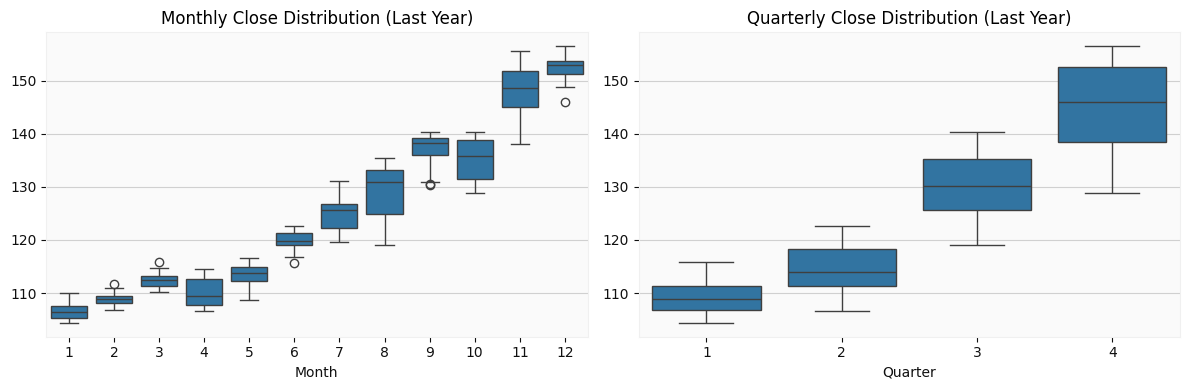

In [116]:
recent = df.last('365D').copy()
recent['Month'] = recent.index.month
recent['Quarter'] = recent.index.quarter

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(x='Month', y=recent['Close'].values.flatten(), data=recent)
plt.title("Monthly Close Distribution (Last Year)")
plt.subplot(1,2,2)
sns.boxplot(x='Quarter', y=recent['Close'].values.flatten(), data=recent)
plt.title("Quarterly Close Distribution (Last Year)")
plt.tight_layout()
plt.show()